<a href="https://colab.research.google.com/github/Rupesh-Kataria/Quora-Duplicate-Question-Pair/blob/main/LSTM_Quora_Duplicate_Question_Pair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [4]:
%cd /mydrive/lstm_duplicate_question_detection

/content/gdrive/My Drive/lstm_duplicate_question_detection


In [7]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c quora-question-pairs

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 97% 301M/309M [00:05<00:00, 24.7MB/s]
100% 309M/309M [00:05<00:00, 63.1MB/s]


In [8]:
!unzip quora-question-pairs.zip
!rm -f quora-question-pairs.zip

Archive:  quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [11]:
!pip install num2words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#basics
import numpy as np
import pandas as pd

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model

#text_processing
from num2words import num2words
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer

#data preperation
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Neural Network
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Embedding, LSTM, Dropout, concatenate, Input, Dense
from tensorflow.keras.layers import Bidirectional, Attention, Reshape, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#other
from tqdm import tqdm
import gc

#warnings
import warnings
warnings.filterwarnings("ignore")

In [9]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
seed=42
batch_size=2048
epochs=30
threshold=0.5

In [8]:
df = pd.read_csv('train.csv.zip')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [12]:
print('df shape:', df.shape)

df shape: (404290, 6)


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [16]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [14]:
df.dropna(inplace=True)

In [15]:
duplicate=df[df['is_duplicate']==1]
not_duplicate=df[df['is_duplicate']==0]

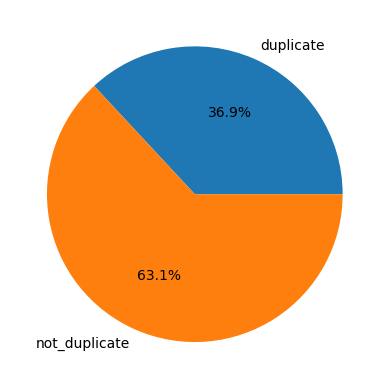

In [16]:
y = np.array([duplicate.shape[0],not_duplicate.shape[0]])
mylabels = ['duplicate','not_duplicate']
plt.pie(y,labels=mylabels,autopct='%1.1f%%')
plt.show()

## Data Preprocessing

In [17]:
#lower casing
def lower_casing(text):
  text=text.lower()
  return text

In [18]:
df['new_ques1']=df['question1'].apply(lower_casing)
df['new_ques2']=df['question2'].apply(lower_casing)

**Replacing Symbols and Short Forms**

In [20]:
def replacements(text):

    text=text.replace('=', ' is equal to ')
    text=text.replace('%', ' percent ')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = text.replace('+', ' plus ')
    text = text.replace('/', ' or ')
    text = text.replace('-', ' ')
    text = text.replace('[math]', '')

    #replacement dict
    replacements_dict = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "I'd": "I would",
        "I'd've": "I would have",
        "I'll": "I will",
        "I'll've": "I will have",
        "I'm": "I am",
        "I've": "I have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so is",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
         "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have",
    }

    # Apply replacements
    pattern = re.compile(r'\b(' + '|'.join(replacements_dict.keys()) + r')\b')
    text = pattern.sub(lambda x: replacements_dict[x.group()], text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    return text

In [21]:
df['new_ques1']=df['new_ques1'].apply(replacements)
df['new_ques2']=df['new_ques2'].apply(replacements)

**Converting numbers to words**

In [22]:
#converting numbers to words
def num_to_words(text):
  #converting numbers to words
  words = text.split()
  converted_text = []
  for word in words:
      if re.match(r'^-?\d+\.?\d*$', word):  # Check if the word is a numeric value
          try:
              converted_word = num2words(float(word))
              converted_text.append(converted_word)
          except ValueError:
              converted_text.append(word)  # If conversion fails, keep the original word
      else:
          converted_text.append(word)

  text=' '.join(converted_text)

  return text

In [23]:
df['new_ques1']=df['new_ques1'].apply(num_to_words)
df['new_ques2']=df['new_ques2'].apply(num_to_words)

**Stemming**

Snowball Stemming, preferred over PorterStemmer and other stemming algorithms, offers several advantages. Firstly, it supports a wide range of languages, making it suitable for multilingual datasets. Secondly, it generates more accurate stems, addressing the limitations of PorterStemmer and providing better results for word forms and variations. Additionally, Snowball Stemming allows for fine-grained control over stemming rules, making it customizable and adaptable to specific requirements.

In [24]:
stemmer = SnowballStemmer('english')

def stem_words(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [25]:
df['new_ques1'] = df['new_ques1'].apply(stem_words)

In [26]:
df['new_ques2'] = df['new_ques2'].apply(stem_words)

**Removing Stopwords**

In [27]:
stop_words=stopwords.words('english')

def remove_stopwords(text):

    new_text=[]
    for word in text.split():
        if word not in stop_words:
            new_text.append(word)

    return ' '.join(new_text)

In [28]:
pbar = tqdm(total=len(df), desc='Removing Stopwords:')
df['new_ques1'] = df['new_ques1'].apply(lambda x: (pbar.update(1), remove_stopwords(x))[1])
df['new_ques2'] = df['new_ques2'].apply(lambda x: (pbar.update(1), remove_stopwords(x))[1])
pbar.close()

Removing Stopwords:: 808574it [00:20, 40126.59it/s]


In [29]:
example=np.random.randint(len(df))
print(df['question1'][example])
print(df['new_ques1'][example])

What are some pentagon-shaped objects?
pentagon shape object


**Vector Representation**

In [30]:
operational_df=df[['new_ques1', 'new_ques2', 'is_duplicate']]

In [31]:
#training and testing sets
train_df, test_df = train_test_split(operational_df, test_size=0.2, random_state=seed)

In [32]:
# Tokenizing the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['new_ques1'].values + train_df['new_ques2'].values)
vocab=tokenizer.word_index

In [34]:
#preparing sequenced data
train_sequences_1 = tokenizer.texts_to_sequences(train_df['new_ques1'].values)
train_sequences_2 = tokenizer.texts_to_sequences(train_df['new_ques2'].values)
test_sequences_1 = tokenizer.texts_to_sequences(test_df['new_ques1'].values)
test_sequences_2 = tokenizer.texts_to_sequences(test_df['new_ques2'].values)

In [35]:
def get_maxlen(data):
    maxlen = 0
    for sent in data:
        maxlen = max(maxlen, len(sent))
    return maxlen

sequences=[train_sequences_1, train_sequences_2, test_sequences_1, test_sequences_2]

max_lengths=[]

for sequence in sequences:
    maxlen = get_maxlen(sequence)
    max_lengths.append(maxlen)

print('Maximum lenght of sentence is:', maxlen)

Maximum lenght of sentence is: 106


we will limit max-lenght to 30. We would not mind missing out on a piece of words from sentences. If we do not limit this maxlen and keep maxlen equal to 106, we would unncessarity create a lot of sparsity in the data

In [36]:
maxlen= 30

In [37]:
train_sequences_1[2:5]

[[3, 97, 76, 1044], [2827, 143], [18, 218, 1616]]

In [38]:
# Pad sequences to a fixed length
train_data_1 = pad_sequences(train_sequences_1, maxlen=maxlen,  padding='post')
train_data_2 = pad_sequences(train_sequences_2, maxlen=maxlen,  padding='post')
test_data_1 = pad_sequences(test_sequences_1, maxlen=maxlen,  padding='post')
test_data_2 = pad_sequences(test_sequences_2, maxlen=maxlen,  padding='post')

In [39]:
train_data_1[2:5]

array([[   3,   97,   76, 1044,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [2827,  143,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [  18,  218, 1616,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [40]:
# Prepare the target labels
train_labels = train_df['is_duplicate'].values
test_labels = test_df['is_duplicate'].values

In [41]:
train_labels

array([0, 1, 0, ..., 1, 0, 0])

Reshaping the labels using np.expand_dims() adds an extra dimension to the labels array, transforming it from a 1D shape to a 2D shape. This ensures that the labels have the same shape as the model's output, allowing them to be properly compared during training and evaluation.

In [43]:
# Reshape the labels to match the model's output shape
train_labels_reshaped = np.expand_dims(train_labels, axis=-1)
test_labels_reshaped = np.expand_dims(test_labels, axis=-1)

In [44]:
train_labels_reshaped

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [0]])

To address to issue of class imbalance, we use class weights during training. Class weights assign different weights to each class, giving more importance to the minority class and less importance to the majority class. This helps in balancing the influence of different classes and mitigating the impact of class imbalance.

In our specific case, the dataset has an imbalance with class 0 having 255,024 samples and class 1 having 149,263 samples. By applying class weights, we aim to give more weight to class 1 during training, allowing the model to focus on learning its patterns effectively.

In [45]:
#class weights
total_samples = len(train_labels)
class_0_count = np.sum(train_labels == 0)
class_1_count = np.sum(train_labels == 1)

weight_0 = total_samples / (2 * class_0_count)
weight_1 = total_samples / (2 * class_1_count)

class_weight = {0: weight_0, 1: weight_1}
class_weight

{0: 0.7927259090775399, 1: 1.3540412455727575}

In [71]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-06-24 05:29:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-06-24 05:29:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-24 05:29:33--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

**GloVE Embedding**

GloVe, short for Global Vectors for Word Representation, is an unsupervised learning algorithm used to obtain dense vector representations (embeddings) for words in a corpus. It is designed to capture the semantic and syntactic meaning of words based on their co-occurrence statistics within the corpus.

In our project, we utilize GloVe embeddings to initialize the embedding layer of our neural network model. By using pre-trained GloVe embeddings, we can benefit from the semantic information captured in these vectors and provide a useful initialization for the word embeddings in our specific task of question similarity classification.

In [46]:
file=open('glove.6B.50d.txt','r', encoding='utf8')
content=file.readlines()
file.close()

In [47]:
#creating word-vector dictionary
embeddings={}

for line in content:
    line = line.split()
    embeddings[line[0]] = np.array(line[1:], dtype = float)

In [48]:
def filter_glove(vocab_dict, glove_dict, wordvec_dim=50):
    '''filter out only words from GloVe dictionary which are present in our corpus'''
    embedding_matrix = np.zeros((len(vocab_dict)+1, wordvec_dim))

    for word, i in vocab_dict.items():
        embedding_vector = glove_dict.get(word)

        if embedding_vector is not None:
        # if the words not found in the glove_dict will be all-zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

embedding_matrix= filter_glove(vocab, embeddings)

## Neural Architecture

In [49]:
#variables
vocab_size = len(tokenizer.word_index) + 1
input_shape = (maxlen,)

In [50]:
# Defining the shared embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=50,
                            weights=[embedding_matrix], input_length=maxlen,
                            trainable=True)  # Fine-tune embeddings

# Defining the input layers for question 1 and question 2
question1_input = Input(shape=input_shape, name='question1_input')
question2_input = Input(shape=input_shape, name='question2_input')

# Applying the embedding layer to both inputs
embedded_question1 = embedding_layer(question1_input)
embedded_question2 = embedding_layer(question2_input)

# Define the Bidirectional LSTM layers
lstm_layer1 = Bidirectional(LSTM(units=32, return_sequences=True))
lstm_layer2 = Bidirectional(LSTM(units=16, return_sequences=True))

# Apply the LSTM layers to both embedded questions
lstm_question1 = lstm_layer1(embedded_question1)
lstm_question2 = lstm_layer1(embedded_question2)

# Apply dropout after the first LSTM layer
dropout1 = Dropout(0.2)(lstm_question1)
dropout2 = Dropout(0.2)(lstm_question2)

# Apply batch normalization after each LSTM layer
bn1 = BatchNormalization()(dropout1)
bn2 = BatchNormalization()(dropout2)

# Apply the second LSTM layer
lstm_question1 = lstm_layer2(bn1)
lstm_question2 = lstm_layer2(bn2)

# Apply attention mechanism
attention1 = Attention()([lstm_question1, lstm_question2])
attention2 = Attention()([lstm_question2, lstm_question1])

# Concatenate the outputs of the attention layers
merged_output = concatenate([attention1, attention2])

# Flatten the merged output
flatten_output = Flatten()(merged_output)

# Add the output layer
output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(flatten_output)

# Creating the Siamese model
model = Model(inputs=[question1_input, question2_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 question1_input (InputLayer)   [(None, 30)]         0           []                               
                                                                                                  
 question2_input (InputLayer)   [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 50)       11333350    ['question1_input[0][0]',        
                                                                  'question2_input[0][0]']        
                                                                                                  
 bidirectional (Bidirectional)  (None, 30, 64)       21248       ['embedding[0][0]',          

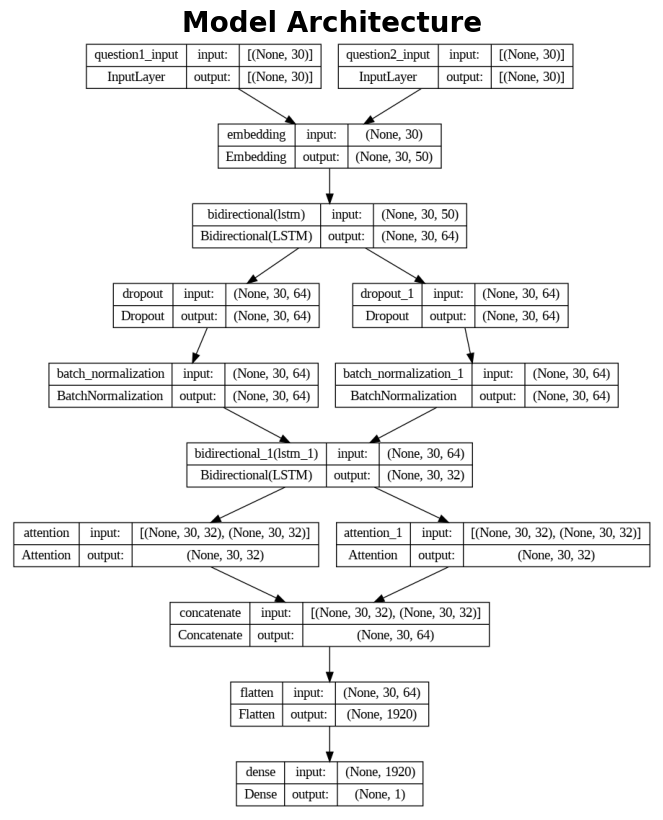

In [52]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Generate the model architecture plot
plot_model(model, to_file='model_architecture.png', show_shapes=True)

# Load the image and add formatting
image = plt.imread('model_architecture.png')
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)

# Add title and remove axes
ax.set_title('Model Architecture', fontsize=20, fontweight='bold')
ax.axis('off')

# Save and display the plot
plt.savefig('formatted_model_architecture.png', bbox_inches='tight', pad_inches=0);

In [53]:
#model1
stopper= EarlyStopping(patience=5, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=3, save_best_only=True)

history=model.fit(
        [train_data_1, train_data_2], train_labels_reshaped,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=([test_data_1, test_data_2], test_labels_reshaped),
         callbacks=[stopper, checkpointer],
         class_weight=class_weight,
         shuffle=True
         )

Epoch 1/30
158/158 [==============================] - ETA: 0s - loss: 0.5763 - accuracy: 0.6939
Epoch 1: val_loss improved from inf to 0.59154, saving model to model.weights.best.hdf5
158/158 [==============================] - 404s 2s/step - loss: 0.5763 - accuracy: 0.6939 - val_loss: 0.5915 - val_accuracy: 0.6865
Epoch 2/30
158/158 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.7635
Epoch 2: val_loss improved from 0.59154 to 0.49722, saving model to model.weights.best.hdf5
158/158 [==============================] - 382s 2s/step - loss: 0.4826 - accuracy: 0.7635 - val_loss: 0.4972 - val_accuracy: 0.7672
Epoch 3/30
158/158 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.7883
Epoch 3: val_loss improved from 0.49722 to 0.45543, saving model to model.weights.best.hdf5
158/158 [==============================] - 384s 2s/step - loss: 0.4411 - accuracy: 0.7883 - val_loss: 0.4554 - val_accuracy: 0.7809
Epoch 4/30
158/158 [========================

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

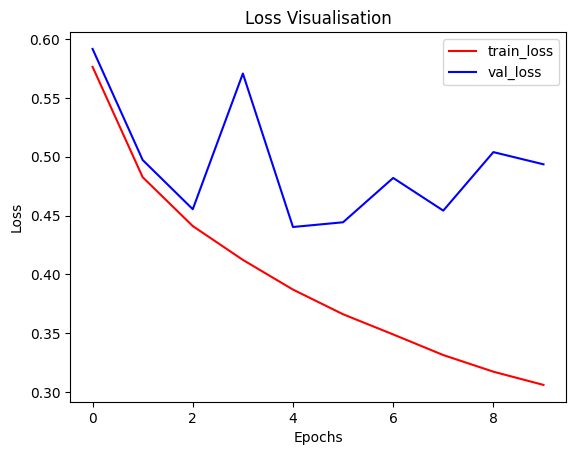

In [55]:
plt.plot(history.history["loss"],color = 'red', label = 'train_loss')
plt.plot(history.history["val_loss"],color = 'blue', label = 'val_loss')
plt.title('Loss Visualisation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Loss_Visualisation.pdf',dpi=1000)

from google.colab import files
files.download('Loss_Visualisation.pdf')

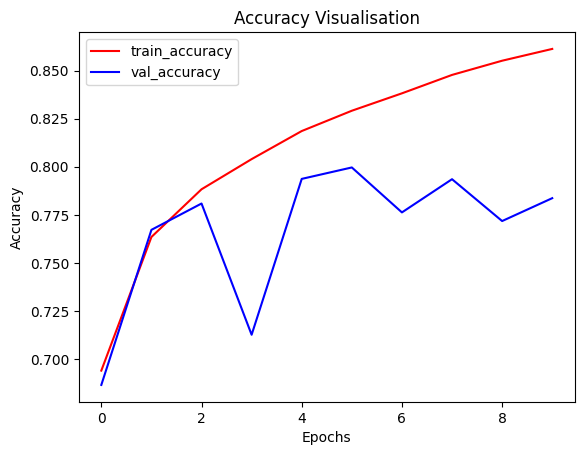

In [56]:
plt.plot(history.history["accuracy"],color = 'red', label = 'train_accuracy')
plt.plot(history.history["val_accuracy"],color = 'blue', label = 'val_accuracy')
plt.title('Accuracy Visualisation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [81]:
#loading best model
model.load_weights('model.weights.best.hdf5')

Testing our model on first 2000 entries of train dataframe

In [82]:
newdf = df.copy()

In [83]:
new_df=newdf[0:2000]

In [84]:
new_df.dropna(inplace=True)

# Operation 2: Convert to lowercase
new_df['new_ques1'] = new_df['question1'].apply(lower_casing)
new_df['new_ques2'] = new_df['question2'].apply(lower_casing)

new_df=new_df.drop(columns=['question1', 'question2'])

# Operation 3: Replace punctuation and short forms
new_df['new_ques1'] = new_df['new_ques1'].apply(replacements)
new_df['new_ques2'] = new_df['new_ques2'].apply(replacements)

# Operation 4: converting numbers to text
new_df['new_ques1'] = new_df['new_ques1'].apply(num_to_words)
new_df['new_ques2'] = new_df['new_ques2'].apply(num_to_words)

# Operation 5: Snowball Stemming
new_df['new_ques1'] = new_df['new_ques1'].apply(stem_words)
new_df['new_ques2'] = new_df['new_ques2'].apply(stem_words)

# Operation 6: Removing Stopwords
new_df['new_ques1'] = new_df['new_ques1'].apply(remove_stopwords)
new_df['new_ques2'] = new_df['new_ques2'].apply(remove_stopwords)

In [85]:
test_seq_que_1 = tokenizer.texts_to_sequences(new_df['new_ques1'].values)
test_seq_que_2 = tokenizer.texts_to_sequences(new_df['new_ques2'].values)

# Pad sequences to a fixed length
test_seq_que_1 = pad_sequences(test_seq_que_1, maxlen=maxlen,  padding='post')
test_seq_que_2 = pad_sequences(test_seq_que_2, maxlen=maxlen,  padding='post')

In [86]:
pred=model.predict([test_seq_que_1, test_seq_que_2])

63/63 [==============================] - 1s 23ms/step


In [87]:
pred

array([[0.65381086],
       [0.01442571],
       [0.00750405],
       ...,
       [0.02680552],
       [0.91988903],
       [0.45944226]], dtype=float32)

In [88]:
pred_binary=(pred > threshold).astype(int)
pred_binary[:10]

array([[1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0]])

In [89]:
y_true=list(new_df['is_duplicate'].values)
y_pred=list(list(pred_binary.ravel()))

In [90]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.83      0.87      1258
           1       0.75      0.85      0.80       742

    accuracy                           0.84      2000
   macro avg       0.83      0.84      0.83      2000
weighted avg       0.85      0.84      0.84      2000



In [91]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,y_pred)

array([[1049,  209],
       [ 111,  631]])